## Importacion de librerias

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from scipy.io import arff
import random
from collections import OrderedDict
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from deap import base, creator, tools, algorithms
from sklearn.base import clone, is_classifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## sklearn-optimize es tomado de: https://github.com/senolakkas/sklearn-optimize
from sklearn_genetic.genetic import GeneticSearchCV

import joblib

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

C:\Users\lmes_\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Leer dataset imputado

In [3]:
# se carga dataset imputado
median_imputed_df = pd.read_pickle(os.path.join('results','median_imputed_data.pkl'))

In [4]:
# función para separar las columnas en variables y etiquetas ('flag')
def split_features_labels(df):
    feature_dfs = df.iloc[:, 1:]
    label_dfs = df['flag']
    return feature_dfs, label_dfs

## Estrategia de validacion

In [27]:
# Validación cruzada mediante K-fold estratificado
def kfold_cv(k, X, y, verbose=False):
    X = X.values  # Variables
    y = y.values  # Etiquetas
    kf = StratifiedKFold(n_splits=k, shuffle=False, random_state=42)
    # inicializamos los sets vacios
    X_train = [] 
    y_train = []
    X_test = []
    y_test = []
    # usamos el split 
    for train_index, test_index in kf.split(X,y):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test
# seteamos la semilla para tener valores random predecibles
seed = 7

In [25]:
# Modelamiento de la data usando un diccionario de datasets y modelos
def perform_data_modeling(_models_, imputed_df, verbose=False, k_folds=5):
    # 7 metricas, usando K-Folds
    # en model_results guardaremos los resultados por clasificador y datasets
    model_results = OrderedDict()

    # Iteramos sobre los clasificadores
    for model_name, clf in _models_.items():
        if verbose: print("-" * 120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()

        # hacemos la division del dataframe en variables y etiquetas
        features_df, labels_df = split_features_labels(imputed_df)

        df_index = 0
        if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index + 1) + 'year' + '\033[0m')
        # Ejecutamos la validación cruzada K-fold en los sets de entranamiento y test
        X_train_list, y_train_list, X_test_list, y_test_list = kfold_cv(k_folds, features_df, labels_df, verbose)

        metrics = OrderedDict()

        # incializamos las metricas a guardar
        accuracy_list = np.zeros([k_folds])
        precision_list = np.zeros([k_folds, 2])
        recall_list = np.zeros([k_folds, 2])
        true_negs = np.zeros([k_folds])
        false_pos = np.zeros([k_folds])
        false_negs = np.zeros([k_folds])
        true_pos = np.zeros([k_folds])

        # Iteramos sobre los k-folds para el cálculo de las métricas
        for k in range(k_folds):
            X_train = X_train_list[k]
            y_train = y_train_list[k]
            X_test = X_test_list[k]
            y_test = y_test_list[k]

            # Fit del modelo 
            clf = clf.fit(X_train, y_train)
            # y predicción en el set de test
            y_test_predicted = clf.predict(X_test)
            # presentamos la matriz de confusión
            print(confusion_matrix(y_test_predicted, y_test))

            # guardamos accuracy y recall
            _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
            accuracy_list[k] = _accuracy_
            _recalls_ = recall_score(y_test, y_test_predicted, average=None)
            recall_list[k] = _recalls_

            # guardamos precision
            _precisions_ = precision_score(y_test, y_test_predicted, average=None)
            precision_list[k] = _precisions_

            # calculamos la matriz de confusión
            _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
            mlp_cm = confusion_matrix(y_test, y_test_predicted)

            # guardamos demás valores: TN, FP, FN, TP
            true_negs[k] = _confusion_matrix_[0][0]
            false_pos[k] = _confusion_matrix_[0][1]
            false_negs[k] = _confusion_matrix_[1][0]
            true_pos[k] = _confusion_matrix_[1][1]

        # Hacemos la media en el caso de más datasets
        metrics['Accuracy'] = np.mean(accuracy_list)
        metrics['Precisions'] = np.mean(precision_list, axis=0)
        metrics['Recalls'] = np.mean(recall_list, axis=0)
        metrics['TN'] = np.mean(true_negs)
        metrics['FP'] = np.mean(false_pos)
        metrics['FN'] = np.mean(false_negs)
        metrics['TP'] = np.mean(true_pos)

        # presentamos algunos valores
        if verbose:
            print('\t\t\tAccuracy:', metrics['Accuracy'])
            print('\t\t\tPrecision:', metrics['Precisions'])
            print('\t\t\tRecall:', metrics['Recalls'])

        # guardamos en el diccionario
        model_results[model_name] = metrics

    # presentamos la matriz de confusión en modo mapa de calor
    sns.heatmap(mlp_cm, annot=True,
                xticklabels=['Non Bankrupt', 'Bankrupt'],
                yticklabels=['Non Bankrupt', 'Bankrupt'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model_results


In [30]:
# Hacer ranking por cada métrica
def perform_model_ranking_acc(models, imputers, results):
    column_headers = ['-','Accuracy'] 
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Accuracy'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_prec(models, imputers, results):
    column_headers = ['-','Precisions']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Precisions'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_rec(models, imputers, results):
    column_headers = ['-','Recalls']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Recalls'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_f1score(models, imputers, results):
    column_headers = ['-','F1-score']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        recall = model_details['Recalls']
        precision = model_details['Precisions']
        f1score = 2*(recall*precision)/(recall+precision)
        row.append(f1score)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_tn(models, imputers, results):
    column_headers = ['-','TN']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['TN'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_fp(models, imputers, results):
    column_headers = ['-','FP']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['FP'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_fn(models, imputers, results):
    column_headers = ['-','FN']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['FN'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_tp(models, imputers, results):
    column_headers = ['-','FP']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['TP'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

## Modelos SVM y SVM+GA

**Hyperparámetros para ajuste**

In [7]:
param = {'kernel': ['rbf'],
          'C': [0, 100], 
          'gamma': [0.01, 0.001]}
param_ga = {"kernel": ["rbf", "sigmoid", "linear"],
             "C": np.logspace(-2, 2, num=25, base=10),
             "gamma": np.logspace(-2, 2, num=25, base=10)}

**Separamos las variables y etiquetas**

In [8]:
X, y = split_features_labels(median_imputed_df) 

**Ahora se hará la búsqueda, si no desea esperar poner 'load' a 1!**

In [10]:
load = 1

In [11]:
# svm búsqueda simple
cv_svm = GridSearchCV(estimator=SVC(), 
                      param_grid=param,
                      scoring="accuracy",
                      cv=5)
if load==0:
  cv_svm.fit(X, y)

In [12]:
# GeneticSearchCV modificado
class GeneticSearchCVMod(GeneticSearchCV):
     def __init__(self, estimator, params, scoring=None, cv=4,
                 refit=True, verbose=False, population_size=50,
                 gene_mutation_prob=0.1, gene_crossover_prob=0.5,
                 tournament_size=3, generations_number=10, gene_type=None,
                 n_jobs=1, iid=True, error_score='raise',
                 fit_params={}):
        super(GeneticSearchCV, self).__init__(
            estimator=estimator, scoring=scoring,
            iid=iid, refit=refit, cv=cv, verbose=verbose,
            error_score=error_score)
        self.fit_params=fit_params
        self.params = params
        self.population_size = population_size
        self.generations_number = generations_number
        self._individual_evals = {}
        self.gene_mutation_prob = gene_mutation_prob
        self.gene_crossover_prob = gene_crossover_prob
        self.tournament_size = tournament_size
        self.gene_type = gene_type
        self.all_history_, self.all_logbooks_ = [], []
        self._cv_results = None
        self.best_score_ = None
        self.best_params_ = None
        self.score_cache = {}
        self.n_jobs = n_jobs
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, est=clone(self.estimator), fitness=creator.FitnessMax)

In [13]:
# svm + ga
cv_svm_ga = GeneticSearchCVMod(estimator=SVC(),
                     params=param_ga,
                     scoring="accuracy",
                     cv=StratifiedKFold(n_splits=4),
                     verbose=1,
                     population_size=20,
                     gene_mutation_prob=0.10,
                     gene_crossover_prob=0.5,
                     tournament_size=3,
                     generations_number=5,
                     n_jobs=4)
if load == 0:
  cv_svm_ga.fit(X, y)

In [17]:
# guardamos los grid-searchs para ahorrar tiempo en futuras ejecuciones
if load == 0:
  joblib.dump(cv_svm, os.path.join('modelos','Modelo_SVM.pkl'))
  joblib.dump(cv_svm_ga, os.path.join('modelos','Modelo_GA_SVM.pkl'))

In [18]:
# cargamos los grid-searchs guardados
if load:
  cv_svm = joblib.load(os.path.join('modelos','Modelo_SVM.pkl'))
  cs_svm_ga = joblib.load(os.path.join('modelos','Modelo_GA_SVM.pkl'))

In [21]:
cs_svm_ga.best_estimator_

SVC(gamma=1e-06, kernel='linear')

In [22]:
svm = cv_svm.best_estimator_
svm_ga = cs_svm_ga.best_estimator_
models_dictionary2 = OrderedDict()
models_dictionary2['SVM'] = svm
models_dictionary2['SVM+GA'] = svm_ga

------------------------------------------------------------------------------------------------------------------------ 
 Model: SVM Classifier
		Dataset: 1year
[[1320   42]
 [   0    2]]
[[1318   44]
 [   2    0]]
[[1320   40]
 [   0    4]]
[[1320   42]
 [   0    2]]
[[1318   43]
 [   1    1]]
			Accuracy: 0.9686169674880535
			Precision: [0.96900288 0.7       ]
			Recall: [0.99954534 0.04090909]
------------------------------------------------------------------------------------------------------------------------ 
 Model: SVM+GA Classifier
		Dataset: 1year
[[1320   42]
 [   0    2]]
[[1319   44]
 [   1    0]]
[[1320   43]
 [   0    1]]
[[1320   42]
 [   0    2]]
[[1318   43]
 [   1    1]]
			Accuracy: 0.9683237123560888
			Precision: [0.96858036 0.7       ]
			Recall: [0.99969685 0.02727273]


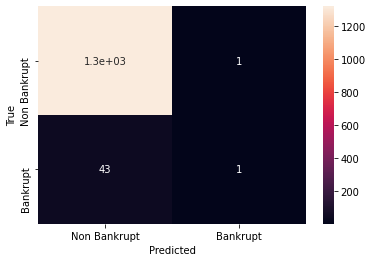

In [28]:
# Cross validación con 5 sets
results2 = perform_data_modeling(models_dictionary2, median_imputed_df, verbose=True, k_folds=5)

In [33]:
print(perform_model_ranking_acc(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_prec(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_rec(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_f1score(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_tn(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_fp(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_fn(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_tp(models_dictionary2, median_imputed_df, results2))

        -  Accuracy
0     SVM  0.968617
1  SVM+GA  0.968324
        -                 Precisions
0     SVM  [0.9690028754852742, 0.7]
1  SVM+GA  [0.9685803576169402, 0.7]
        -                                    Recalls
0     SVM  [0.9995453396742253, 0.04090909090909091]
1  SVM+GA  [0.9996968548257403, 0.02727272727272727]
        -                                  F1-score
0     SVM  [0.984037171011077, 0.07730061349693251]
1  SVM+GA              [0.9838926458473582, 0.0525]
        -      TN
0     SVM  1319.2
1  SVM+GA  1319.4
        -   FP
0     SVM  0.6
1  SVM+GA  0.4
        -    FN
0     SVM  42.2
1  SVM+GA  42.8
        -   FP
0     SVM  1.8
1  SVM+GA  1.2
